In [1]:
%reset -f
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.contrib.autoguide as autoguide
pyro.enable_validation(True)

In [2]:
# ratings = pd.read_csv('ratings.csv')

# person_index = list(ratings['userId'].value_counts().keys())
# movie_index = list(ratings['movieId'].value_counts().keys())

# num_of_users = len(person_index)
# num_of_movies = len(movie_index)

# ratings = ratings.values[:,:3]

# mat  = np.zeros((num_of_users, num_of_movies))
# for idx, rate in enumerate(ratings):
#     if(idx%1000 == 0):
#         print(".", end='')
#     row = person_index.index(rate[0])
#     col = movie_index.index(rate[1])
#     mat[row][col] = rate[2]

# data_truth = torch.tensor(mat)
# torch.save(data_truth, 'data_ratings.pt')


In [3]:
data_truth = torch.load('data_ratings.pt').float()

In [4]:
data_truth

tensor([[5.0000, 5.0000, 5.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.5000, 4.0000, 5.0000,  ..., 1.5000, 0.0000, 0.0000],
        [3.0000, 5.0000, 4.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [3.0000, 0.0000, 5.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [400]:
# adding self-made mask
num_people = 8
num_movies = 100
data = data_truth[:num_people,:num_movies].clone()
data_real_missing = torch.zeros_like(data_truth[:num_people,:num_movies])
data_real_missing[data_truth[:num_people,:num_movies]==0]=1.

for i in range(num_people):
    missing_index = np.random.choice(np.arange(0,num_movies), replace=False, size=np.random.randint(low=15, high=25))
    for index in missing_index:
        data[i, index] = 0.

data_which_missing = torch.zeros_like(data)
data_which_missing[data==0] = 1.

# data_truth_01 = data_truth[:num_people,:num_movies].clone()
# data_truth_01[data_truth[:num_people,:num_movies]==0] = -1
# data_truth_01[data_truth[:num_people,:num_movies]==-1] = -2

In [401]:
def multi_sigmoid(x, thresholds, w):
    value = torch.tensor(0.5)
    for threshold in thresholds:
        value = value + 0.5 * 1/(1+torch.exp(-w*(x-threshold)))
    return value
thresholds = torch.arange(-9,9,2).float()
w = torch.tensor(5.)

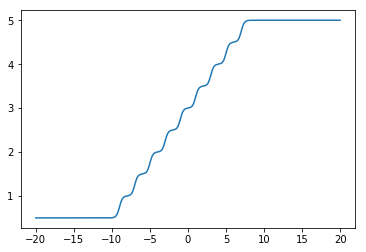

In [402]:
xx = torch.linspace(-20,20,1000)
plt.plot(xx.numpy(), multi_sigmoid(xx, thresholds, w).numpy())
plt.show()

In [403]:
data.shape

torch.Size([8, 100])

In [579]:
def model_with_star(y, num_traits):
    num_people, num_movies = y.shape
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    mean_threshold = torch.tensor(0.)
    std_threshold = torch.tensor(1.)
#     w = torch.tensor(0.05)

    mean_w = torch.tensor(4.)
    std_w = torch.tensor(0.1)
    w = pyro.sample("w", dist.Normal(mean_w, std_w))
    
    people = pyro.plate("people", num_people)
    with pyro.plate("traits", num_traits):
        with people:
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("unroot_movies", num_movies - num_traits):
            unknown_trait = pyro.sample("unknown_trait", dist.Normal(mean_trait,std_trait))
        with pyro.plate("root_movies", num_traits):
            known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.eye(num_traits) )
    trait = torch.cat((known_trait, unknown_trait), 0)
    affinity = torch.mm(pref, trait.transpose(0,1))
    
    with pyro.plate("stars", 8):
        thresholds = pyro.sample("thresholds",dist.Normal(mean_threshold, std_threshold))
    threshold_3star = pyro.sample("threshold_3star", dist.Normal(mean_threshold, std_threshold), obs = torch.tensor(0.))
    thresholds = torch.cat((thresholds[:4], threshold_3star.reshape((1)), thresholds[4:]))
    
    is_observed = (y != 0)
    with pyro.poutine.mask(mask=is_observed):
        with pyro.plate("movies", num_movies):
            with people:
                noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
#                 print('model w = ',w)
                ms = multi_sigmoid(noisy_affinity, thresholds, w)
                has_star = pyro.sample('has_star',dist.Normal(ms, 0.1), obs = y)
  
    
# guide1 = autoguide.AutoDiagonalNormal(model_with_star)

def guide(y, num_traits):
    num_people, num_movies = y.shape
    
    mean_pref = pyro.param("mean_pref", torch.zeros(num_people, num_traits))
    std_pref = pyro.param("std_pref", torch.ones(num_people, num_traits), constraint=constraints.positive)
    mean_trait = pyro.param("mean_trait", torch.zeros(num_movies-num_traits, num_traits))
    std_trait = pyro.param("std_trait", torch.ones(num_movies-num_traits, num_traits), constraint=constraints.positive)
    mean_threshold = pyro.param("mean_threshold", torch.zeros(8))
    std_threshold = pyro.param("std_threshold", torch.ones(8), constraint=constraints.positive)
    
#     print(mean_pref)
    
    mean_w = pyro.param("mean_w", torch.tensor(5.), constraint=constraints.positive)
    std_w = pyro.param("std_w", torch.tensor(0.1), constraint=constraints.positive)
    w = pyro.sample("w", dist.Normal(mean_w, std_w))    
    
#     w = pyro.param("w", torch.tensor(5.))
    
    people = pyro.plate("people", num_people)
    with pyro.plate("traits", num_traits):
        with people:
            pref = pyro.sample("pref",dist.Normal(mean_pref, std_pref))
        with pyro.plate("unroot_movies", num_movies - num_traits):
            unknown_trait = pyro.sample("unknown_trait", dist.Normal(mean_trait, std_trait))
    known_trait = torch.eye(num_traits)
    trait = torch.cat((known_trait, unknown_trait), 0)
    affinity = torch.mm(pref, trait.transpose(0,1))

    with pyro.plate("stars", 8):
        thresholds = pyro.sample("thresholds",dist.Normal(mean_threshold, std_threshold))
    
    with pyro.plate("movies", num_movies):
        with people:
            noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
    
    

..................................................2642.016046524048


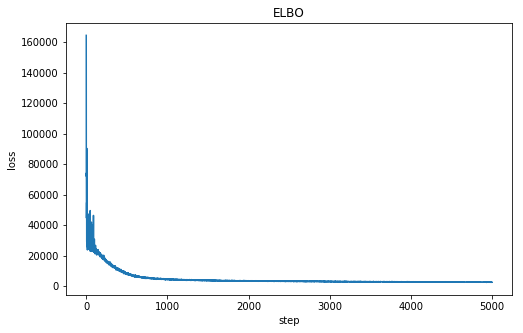

In [580]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_with_star,
                     guide=guide,
#                      optim=pyro.optim.Adam({"lr": 0.005, "betas": (0.90, 0.999)}),
                     optim=pyro.optim.SGD({"lr": 0.0001, "momentum":0.00005}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
training_acc = []
testing_acc = []
num_steps = 5000
num_traits = 5
for i in range(num_steps):
    losses.append(svi.step(data.float(), num_traits))
    if(i%100==0):
#         print(pyro.param("w").data)
#         print(pyro.param("mean_pref").data)
#         print(pyro.param("w").data)
#         print(losses[-1])
#         testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
#         total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
#         count = torch.sum((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float()*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
#         testing_acc.append(count/total)
#         total = torch.sum(data_which_missing[:,num_traits:]-1)
#         count = torch.sum((data_which_missing[:,num_traits:]-1)*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
#         training_acc.append(count/total)
        print(".", end='')
print(losses[-1])
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()


In [581]:
pyro.param("mean_w").data

tensor(4.1247)

tensor(4.1247)
tensor([-1.2903, -6.7891,  2.8987, -5.0574,  1.7641, -4.0308, -8.4852, -6.7891,
         0.0000])


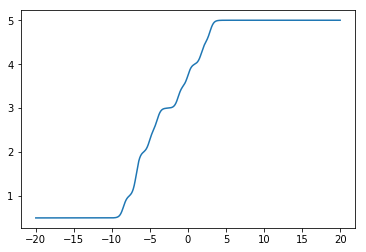

In [582]:
w = pyro.param("mean_w").data
threshold = pyro.param("mean_threshold").data
thresholds = torch.cat((pyro.param("mean_threshold").data, torch.tensor([0.])))
print(w)
print(thresholds)
xx = torch.linspace(-20,20,1000)
plt.plot(xx.numpy(), multi_sigmoid(xx, thresholds, w).numpy())
plt.show()

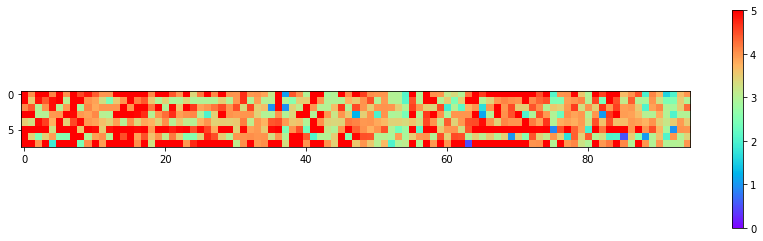

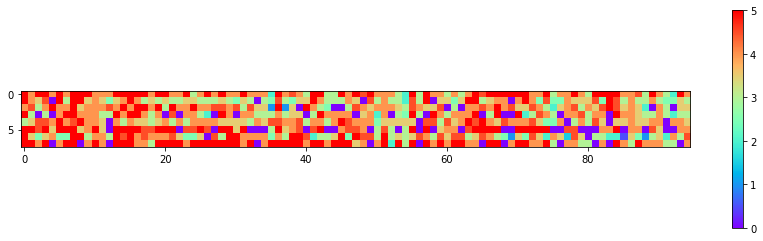

In [599]:
testing_affinity = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
thresholds = torch.cat((pyro.param("mean_threshold").data, torch.tensor([0.])))
prediction = multi_sigmoid(testing_affinity, thresholds, w)
plt.figure(figsize=(15,4)) 
plt.imshow(prediction, cmap='rainbow', vmin=-0., vmax=5.)
plt.colorbar()
plt.show()

plt.figure(figsize=(15,4)) 
plt.imshow(data_truth[:num_people,num_traits:num_movies], cmap='rainbow', vmin=-0., vmax=5.)
plt.colorbar()
plt.show()

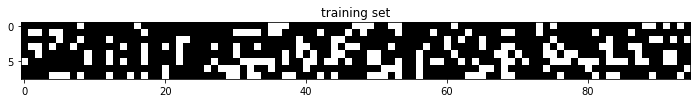

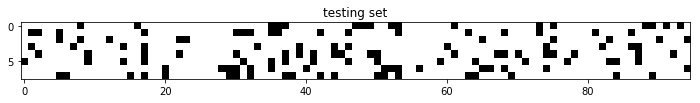

In [600]:
plt.figure(figsize=(12,3)) 
plt.imshow(-data_which_missing[:,num_traits:]+1, cmap='binary', vmin=0, vmax=1.)
plt.title('training set')
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float(), cmap='binary', vmin=0, vmax=1.)
plt.title('testing set')
plt.show()



In [601]:
prediction_correctness = torch.zeros((num_people, num_movies - num_traits))
for i in range(num_people):
    for j in range(num_movies - num_traits):
        if torch.abs(prediction[i,j] - data_truth[:num_people,num_traits:num_movies][i,j]) < 0.25:
            prediction_correctness[i,j] = 1.
testing_total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
testing_count = torch.sum(( data_which_missing[:,num_traits:] != data_real_missing[:,num_traits:] ).float() * prediction_correctness)
print('testing acc', testing_count/testing_total)
training_total = torch.sum(data_which_missing[:,num_traits:]-1.)
training_count = torch.sum(( data_which_missing[:,num_traits:]-1. ) * prediction_correctness)
print('training acc', training_count/training_total)


testing acc tensor(0.3359)
training acc tensor(0.9140)
